**Brian Blaylock**  
**September 15, 2020**

# 🌎 Create GOES ABI latitude and longitude grids
The ABI files do not contain a lat/lon grid, but does contain all the projection information you need to create one.

Here, I have created regular grids for the Cloud and Moisture Multichannel product for the following grids:
- GOES-17 : CONUS
- GOES-17 : Full Disk
- GOES-16 : CONUS
- GOES-16 : Full Disk

In [1]:
import s3fs
from pyproj import Proj
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from BB_GOES.goes_retrieve import goes_timerange

ModuleNotFoundError: No module named 'dask'

In [2]:
# satellite = 'goes17'
# domain = 'C'

In [3]:
%%time

satellite = "goes16"
domain = "C"

start = datetime(2020, 9, 1)
end = start + timedelta(minutes=5)

# ABI = goes_timerange(start, end, satellite, 'ABI', domain=domain, return_data='download')
ABI = goes_timerange(start, end, satellite, "ABI", domain=domain)

🥇 Retrieved 1 files from AWS [goes16/ABI-L2-MCMIPC].                                                                                                                                                       
CPU times: user 180 ms, sys: 52 ms, total: 232 ms
Wall time: 1.08 s


In [4]:
p = ABI["goes_imager_projection"]

# The projection x and y coordinates equals the scanning angle (in radians)
# multiplied by the satellite height See details here:
# https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = ABI["x"][:] * p.perspective_point_height
y = ABI["y"][:] * p.perspective_point_height

######################################################################
# The geostationary projection is the easiest way to plot the image on a
# map. Essentially, we are stretching the image across a map with the same
# projection and dimensions as the data.

try:
    print("first try...", end="")
    globe = ccrs.Globe(
        semimajor_axis=p.semi_major_axis,
        semiminor_axis=p.semi_minor_axis,
        inverse_flattening=p.inverse_flattening,
    )
    geos = ccrs.Geostationary(
        central_longitude=p.longitude_of_projection_origin,
        satellite_height=p.perspective_point_height,
        sweep_axis=p.sweep_angle_axis,
        globe=globe,
    )

except:
    print("second try")
    globe = ccrs.Globe(
        semimajor_axis=p.semi_major_axis[0],
        semiminor_axis=p.semi_minor_axis[0],
        inverse_flattening=p.inverse_flattening[0],
    )
    geos = ccrs.Geostationary(
        central_longitude=p.longitude_of_projection_origin[0],
        satellite_height=p.perspective_point_height[0],
        sweep_axis=p.sweep_angle_axis,
        globe=globe,
    )

first try...

In [5]:
geos

In [6]:
# For fun, lets get the True Color RGB
def get_TrueColor_RGB(C):
    R = C["CMI_C02"].data
    G = C["CMI_C03"].data
    B = C["CMI_C01"].data

    # Apply range limits for each channel. RGB values must be between 0 and 1
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    # Apply a gamma correction to the image
    gamma = 2.2
    R = np.power(R, 1 / gamma)
    G = np.power(G, 1 / gamma)
    B = np.power(B, 1 / gamma)

    # Calculate the "True" Green
    G_true = 0.45 * R + 0.1 * G + 0.45 * B
    G_true = np.maximum(G_true, 0)
    G_true = np.minimum(G_true, 1)

    return np.dstack([R, G_true, B])


RGB_true = get_TrueColor_RGB(ABI)

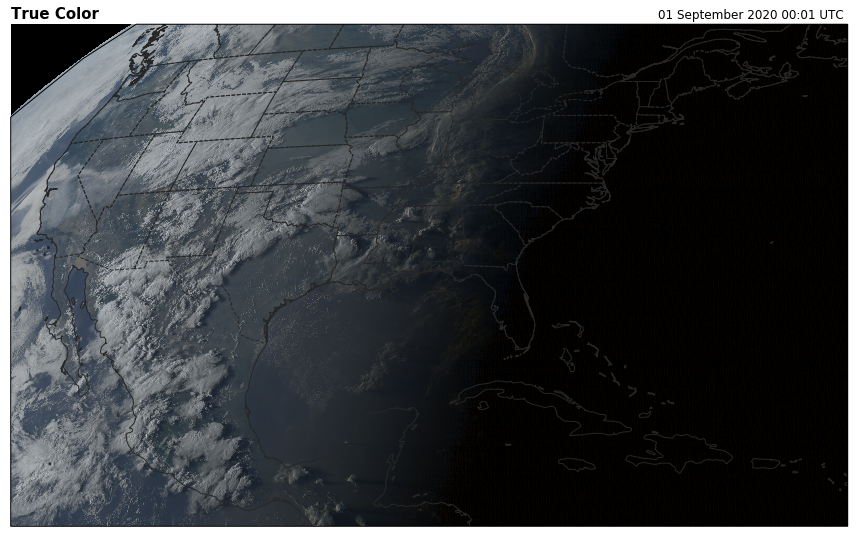

In [7]:
fig = plt.figure(figsize=(15, 12))

ax = fig.add_subplot(1, 1, 1, projection=geos)

ax.imshow(
    RGB_true,
    origin="upper",
    extent=(x.min(), x.max(), y.min(), y.max()),
    transform=geos,
    interpolation="nearest",
    vmin=162.0,
    vmax=330.0,
)
ax.coastlines(resolution="50m", color=".15", linewidth=1)
ax.add_feature(
    ccrs.cartopy.feature.STATES.with_scale("50m"), linestyle="--", edgecolor=".15"
)

plt.title("True Color", loc="left", fontweight="semibold", fontsize=15)

str_date = pd.to_datetime(ABI.time_coverage_start.data).strftime("%d %B %Y %H:%M UTC ")
plt.title("%s" % str_date, loc="right");

In [8]:
X, Y = np.meshgrid(x, y)
a = ccrs.PlateCarree().transform_points(geos, X, Y)

In [9]:
lons, lats, _ = a[:, :, 0], a[:, :, 1], a[:, :, 2]

In [10]:
lons

array([[          inf,           inf,           inf, ...,  -53.01758429,
         -52.9822372 ,  -52.94687282],
       [          inf,           inf,           inf, ...,  -53.03919233,
         -53.00388897,  -52.9685684 ],
       [          inf,           inf,           inf, ...,  -53.06072004,
         -53.02546023,  -52.99018326],
       ...,
       [-113.08533629, -113.05799641, -113.03067247, ...,  -61.94596491,
         -61.92643289,  -61.90689839],
       [-113.08005349, -113.05271984, -113.02540212, ...,  -61.94735934,
         -61.92782954,  -61.90829726],
       [-113.07477947, -113.04745204, -113.02014053, ...,  -61.94875163,
         -61.92922405,  -61.90969399]])

In [28]:
lats[np.isinf(lats)] = np.nan
lons[np.isinf(lons)] = np.nan

ds = xr.Dataset(dict(latitude=(("y", "x"), lats), longitude=(("y", "x"), lons)))

ds.latitude.attrs = dict(
    standard_name="latitude", long_name="latitude", units="degrees_north"
)
ds.longitude.attrs = dict(
    standard_name="longitude", long_name="longitude", units="degrees_east"
)

ds.coords["latitude"] = ds.latitude
ds.coords["longitude"] = ds.longitude

if domain == "C":
    D = "CONUS"
elif domain == "F":
    D = "Full-Disk"

ds.attrs["name"] = f"lat/lon grid for {satellite} {D}"
ds.attrs["author"] = "Brian K. Blaylock"
ds.attrs["created"] = f"{datetime.now():%Y-%m-%d %H:%M}"
ds.attrs["history"] = ""

ds = ds.where(~np.isinf(ds.latitude))
ds = ds.where(~np.isinf(ds.longitude))

name = f"./latlon_{satellite}-{domain}.nc"
ds.to_netcdf(name)
ds

<xarray.Dataset>
Dimensions:    (x: 2500, y: 1500)
Coordinates:
    latitude   (y, x) float64 nan nan nan nan nan ... 14.64 14.64 14.64 14.64
    longitude  (y, x) float64 nan nan nan nan ... -61.97 -61.95 -61.93 -61.91
Dimensions without coordinates: x, y
Data variables:
    *empty*
Attributes:
    name:     lat/lon grid for goes16 CONUS
    author:   Brian K. Blaylock
    created:  2020-09-15 23:43
    history:

In [25]:
lats[np.isinf(lats)] = np.nan

In [26]:
lats

array([[        nan,         nan,         nan, ..., 51.36047934,
        51.36249181, 51.36450827],
       [        nan,         nan,         nan, ..., 51.32221062,
        51.32421725, 51.32622787],
       [        nan,         nan,         nan, ..., 51.28399392,
        51.28599476, 51.28799956],
       ...,
       [15.16044982, 15.15968922, 15.15892952, ..., 14.67643652,
        14.67663608, 14.67683596],
       [15.14051229, 15.13975293, 15.13899447, ..., 14.65725591,
        14.65745517, 14.65765474],
       [15.12057682, 15.1198187 , 15.11906148, ..., 14.63807676,
        14.63827571, 14.63847499]])

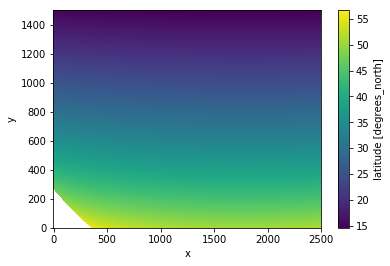

In [33]:
xr.open_dataset(name).latitude.plot()

In [31]:
name

'./latlon_goes16-C.nc'

In [15]:
ABI

<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 2500, y: 1500)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.128212 ... 0.044268005
  * x                                       (x) float32 -0.101332 ... 0.038612
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    band_wavelength_C02                     (band) float32 ...
    band_wavelength_C03                     (band) float32 ...
    band_wavelength_C04                     (band) float32 ...
    band_wavelength_C05                     (band) float32 ...
    band_wavelength_C06                     (band) float32 ...
    band_wavelength_C07                     (band) float32 ...
    band_wavelength_C08                     (band) float32 ...
    band_wavelength_C09                     (band) float32 ...
    band_wavelength_C10                     (band) float32 ...
    band_wavelength_C11                     (band) float32 ...
    band_wavelength_C12                     (band) float32 ...
    band_wavelength_C13                     (band) float32 ...
    band_wavelength_C14                     (band) float32 ...
    band_wavelength_C15                     (band) float32 ...
    band_wavelength_C16                     (band) float32 ...
    band_id_C01                             (band) int8 ...
    band_id_C02                             (band) int8 ...
    band_id_C03                             (band) int8 ...
    band_id_C04                             (band) int8 ...
    band_id_C05                             (band) int8 ...
    band_id_C06                             (band) int8 ...
    band_id_C07                             (band) int8 ...
    band_id_C08                             (band) int8 ...
    band_id_C09                             (band) int8 ...
    band_id_C10                             (band) int8 ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
    dataset_name                            <U74 'OR_ABI-L2-MCMIPC-M6_G16_s20...
    date_created                            <U22 '2020-09-01T00:04:09.8Z'
    time_coverage_start                     <U22 '2020-09-01T00:01:16.9Z'
    time_coverage_end                       <U22 '2020-09-01T00:03:54.8Z'
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables:
    CMI_C01                                 (y, x) float32 nan nan ... 0.0 0.0
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 nan nan ... 0.0 0.0
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 nan nan ... 0.0 0.0
    DQF_C03                                 (y, x) float32 ...
    CMI_C04                                 (y, x) float32 ...
    DQF_C04                                 (y, x) float32 ...
    CMI_C05                                 (y, x) float32 ...
    DQF_C05                                 (y, x) float32 ...
    CMI_C06                                 (y, x) float32 ...
    DQF_C06                                 (y, x) float32 ...
    CMI_C07                                 (y, x) float32 ...
    DQF_C07                                 (y, x) float32 ...
    CMI_C08                                 (y, x) float32 ...
    DQF_C08                                 (y, x) float32 ...
    CMI_C09                                 (y, x) float32 ...
    DQF_C09         